In [1]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

In [2]:
cd

/Users/keith_tetrad


In [3]:
#import data

#flow data
sample_data = pd.DataFrame(pd.read_csv('kw_dms/Titering lentivirus/individual_variant/20240610_KWTITER-Batch_Analysis_10062024205253.csv',delimiter=',', usecols=['Specimen Name','Well Name','singlet #Events', 'FITC %Parent']))

#sample scheme
sample_scheme = pd.DataFrame(pd.read_csv('kw_dms/Titering lentivirus/individual_variant/sample_scheme.csv', delimiter=',', usecols=['Specimen Name', 'column', 'variant', 'treatment']))


In [4]:
# merge sample_scheme with flow data

# Mapping for Well Name to column numbers
well_map = {f"{letter}{number}": number for letter in 'ABCDEFGH' for number in range(1, 13)}

# Adding column information to sample_data
sample_data['column'] = sample_data['Well Name'].map(lambda x: well_map[x])

# Merging sample_data with sample_scheme
merged_data = pd.merge(sample_data, sample_scheme, on=['Specimen Name', 'column'], how='left')

# Dropping the 'column' column as it is no longer needed
merged_data = merged_data.drop(columns=['column'])

# Assign variant source in new column 'variant_source'
def assign_variant_source(row):
    if row['variant'] in ['Lib','pKW144']:
        return 'control'
    elif row['variant'] in ['pKW194','pKW195','pKW196','pKW197']:
        return 'in_all_three'
    elif row['variant'] in ['pKW198','pKW199','pKW200','pKW201']:
        return 'in_4u8c_and_Both'
    else:
        return 'in_C7_and_Both'

merged_data['variant_source'] = merged_data.apply(assign_variant_source, axis=1)


In [5]:
#add dilution scheme

# Adding the dilution information
dilution_map = {
    'A': 0.5,
    'B': 0.1666667,
    'C': 0.0555556,
    'D': 0.0185185,
    'E': 0.5,
    'F': 0.1666667,
    'G': 0.0555556,
    'H': 0.0185185
}

# Extracting the letter part of the Well Name and mapping to dilution
merged_data['dilution'] = merged_data['Well Name'].str[0].map(dilution_map)

In [6]:
#Calculate titers using the Poisson formula. 
#If P is the percentage of cells that are ZsGreen positive, then the titer per ml is: -ln(1 − P/100) × (number of cells/well)/(volume of virus per well in mL)
#volume of virus per well well = (150 µL * dilution) = 0.15 mL * dilution

cells_counted = 1
merged_data['TU'] = np.abs(-np.log(1-(merged_data['FITC %Parent']/100))*(cells_counted/(0.15*merged_data['dilution'])))

In [7]:
#drop samples that had less than 1% or more than 10% FITC stained cells 
filtered_sample_data = merged_data[(merged_data['FITC %Parent'] <= 10) & (merged_data['singlet #Events'] > 1000)]  

# filtered_sample_data = merged_data

In [8]:
#Calculate mean and SEM for each sample
mean = (filtered_sample_data.groupby(['variant','treatment'], as_index=False)['TU'].mean()).rename(columns={'TU': 'mean'})
sem = (filtered_sample_data.groupby(['variant','treatment'], as_index=False)['TU'].sem()).rename(columns={'TU': "sem"})

merged = mean.merge(sem, on = ['variant', 'treatment'])


In [9]:
normalized_data = []
for variant, group in merged.groupby('variant'):
    dmso_mean = group.loc[group['treatment'] == 'DMSO', 'mean'].values[0]
    dmso_sem = group.loc[group['treatment'] == 'DMSO', 'sem'].values[0]
    group['fold_change'] = group['mean'] / dmso_mean
    group['fold_change_sem'] = group['fold_change'] * np.sqrt((group['sem'] / group['mean'])**2 + (dmso_sem / dmso_mean)**2)
    normalized_data.append(group)
    
# Concatenate list of DataFrames into a single DataFrame
normalized_df = pd.concat(normalized_data)

In [10]:
normalized_WT = []

for treatment, group in normalized_df.groupby('treatment'):
    wt_fold_change = group.loc[group['variant'] == 'pKW144', 'fold_change'].values[0]
    wt_sem = group.loc[group['variant'] == 'pKW144', 'fold_change_sem'].values[0]
    group['fold_change_rel_wt'] = group ['fold_change'] / wt_fold_change
    group['fold_change_sem_rel_wt'] = group['fold_change'] * np.sqrt((group['fold_change_sem'] / group['fold_change'])**2 + (wt_sem / wt_fold_change)**2)
    normalized_WT.append(group)

# Concatenate list of DataFrames into a single DataFrame
normalized_wt_df = pd.concat(normalized_WT)

normalized_wt_df['variant_source'] = normalized_wt_df.apply(assign_variant_source, axis=1)

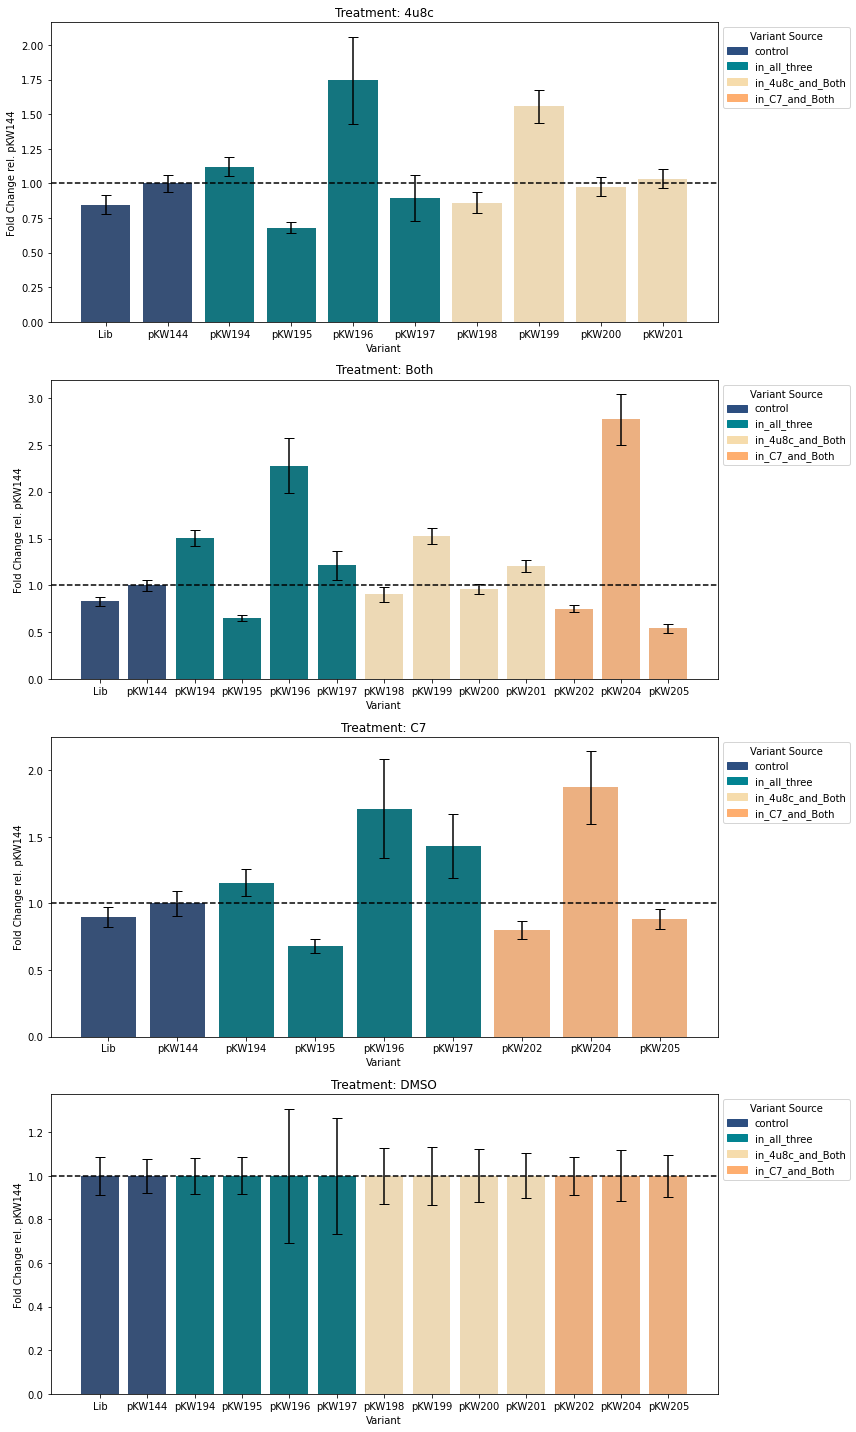

In [11]:
# Create a color palette
palette = {
    'control': '#2C4E80',
    'in_all_three': '#028391',
    'in_4u8c_and_Both': '#F6DCAC',
    'in_C7_and_Both': '#FEAE6F'
}

# Create a new column in your DataFrame to hold the colors
normalized_wt_df['color'] = normalized_wt_df['variant_source'].map(palette)

# Plotting each treatment separately without specifying the order of variants
num_treatments = normalized_wt_df['treatment'].nunique()
fig, axes = plt.subplots(num_treatments, 1, figsize=(12, num_treatments * 5))

# Plot each treatment separately
for i, (treatment, group) in enumerate(normalized_wt_df.groupby('treatment')):
    sns.barplot(data=group, x='variant', y='fold_change_rel_wt', palette=group['color'], ax=axes[i])
    for j, variant in enumerate(group['variant']):
        y = group[group['variant'] == variant]['fold_change_rel_wt'].values[0]
        yerr = group[group['variant'] == variant]['fold_change_sem_rel_wt'].values[0]
        axes[i].errorbar(
            x=j, 
            y=y, 
            yerr=yerr, 
            fmt='none', 
            c='black', 
            capsize=5
        )
    axes[i].axhline(y=1, color='black', linestyle='--')
    axes[i].set_title(f'Treatment: {treatment}')
    axes[i].set_ylabel('Fold Change rel. pKW144')
    axes[i].set_xlabel('Variant')

    # Create a list of patches for the legend
    patches = [Patch(color=color, label=label) for label, color in palette.items()]

    # Add the legend outside the plot
    axes[i].legend(handles=patches, title='Variant Source', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()